In [17]:
### google drive mount
from google.colab import drive
drive.mount ('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [18]:
### necessary imports
import pandas as pd
import numpy as np
from numpy import  random
from math import floor
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Input, concatenate
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
### read data for 2 stocks AAL and GOOGL
aal_stock_data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Deep Neural Nets/Project/AAL_data.csv',delimiter=',', encoding='ISO-8859–1')
googl_stock_data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Deep Neural Nets/Project/GOOGL_data.csv',delimiter=',', encoding='ISO-8859–1')

# from the pandas dictionary keep only close prices for the stock AAL
aal_stock_data_close = aal_stock_data[['close']]

# get min/max value for the close prices, in order to create the data for the prevention module
aal_max_close = aal_stock_data_close.max()
aal_min_close = aal_stock_data_close.min()
prevention_module_data = []

# the prevention module includes random values from the uniform distribution between the min and max closing price of the stock
for i in range(aal_stock_data_close.shape[0]):
    prevention_module_data.append(random.uniform(aal_min_close, aal_max_close))

# convert list to numpy array
prevention_module_data = np.array(prevention_module_data)


# repeat the above process for GOOGL stock
googl_stock_data_close = googl_stock_data[['close']]
googl_max_close = googl_stock_data_close.max()
googl_min_close = googl_stock_data_close.min()
googl_prevention_module_data = []
for i in range(googl_stock_data_close.shape[0]):
    googl_prevention_module_data.append(random.uniform(googl_min_close, googl_max_close))

googl_prevention_module_data = np.array(googl_prevention_module_data)

In [20]:
# the below function divides the initial data to training, validation and test set
# the percentages are 70%, 10% and 20% respectively
def get_train_validation_test_sets(stock):
    data = stock.to_numpy() # convert to numpy array

    val_test_set_size = int(np.round(0.3*data.shape[0])); # validation and test set size together
    train_set_size = data.shape[0] - (val_test_set_size);

    train_data = data[:train_set_size]

    validation_data = data[train_set_size:floor(train_set_size + val_test_set_size/3)]
  
    test_data = data[floor(train_set_size + val_test_set_size/3):]
    
    return [train_data, validation_data, test_data]

# get the train, validation and test data from initial AAL closing stock prices
train_data, validation_data, test_data = get_train_validation_test_sets(aal_stock_data_close)

# breakdown the prevention module input data accordingly for train, validation and test
train_prevention_module_data = prevention_module_data[:train_data.shape[0], :]
validation_prevention_module_data = prevention_module_data[train_data.shape[0]:(train_data.shape[0] + validation_data.shape[0]), :]
test_prevention_module_data = prevention_module_data[-test_data.shape[0]:, :]

#### repeat the above process for GOOGL stock but just for test since we only want this to test our model in an "unknown" stock
_, _, googl_test_data = get_train_validation_test_sets(googl_stock_data_close)
googl_test_prevention_module_data = googl_prevention_module_data[-googl_test_data.shape[0]:, :]

In [21]:
# create a MinMax scaler for AAL
aal_scaler = MinMaxScaler(feature_range=(0, 1))

# fit and transform train, validation and test prevention module data for AAL
train_prevention_module_data = aal_scaler.fit_transform(train_prevention_module_data.reshape(-1,1))
validation_prevention_module_data = aal_scaler.fit_transform(validation_prevention_module_data.reshape(-1,1))
test_prevention_module_data = aal_scaler.fit_transform(test_prevention_module_data.reshape(-1,1))

# fit and transform train, validation and test data for AAL
train_data = aal_scaler.fit_transform(train_data.reshape(-1,1))
validation_data = aal_scaler.fit_transform(validation_data.reshape(-1,1))
test_data = aal_scaler.fit_transform(test_data.reshape(-1,1))

# repeat the above process for GOOGL
googl_scaler = MinMaxScaler(feature_range=(0, 1))

googl_test_prevention_module_data = googl_scaler.fit_transform(googl_test_prevention_module_data.reshape(-1,1))

googl_test_data = googl_scaler.fit_transform(googl_test_data.reshape(-1,1))

In [22]:
# the below function splits the data in "windows" of lookback size
# for each window the next value in the dataset is the corresponding output
def split_data(data_raw, lookback):
    x = []
    y = []
    for i in range(lookback, data_raw.shape[0]):
        x.append(data_raw[i-lookback:i, 0])
        y.append(data_raw[i, 0])

    x, y = np.array(x), np.array(y)
    x = np.reshape(x, (x.shape[0], x.shape[1], 1))
    
    return [x, y]


lookback = 20 # desired time series sequence length, tested for 10, 20, 30 and 50

# create the x and y train, validation and test data for AAL
x_train, y_train = split_data(train_data, lookback)
x_validation, y_validation = split_data(validation_data, lookback)
x_test, y_test = split_data(test_data, lookback)

# for each window in the prediction module we create also a window of the same size in the prevention module
# though here we do not need the output data
prevention_module_data_train, _ = split_data(train_prevention_module_data, lookback)
prevention_module_data_validation, _ = split_data(validation_prevention_module_data, lookback)
prevention_module_data_test, _ = split_data(test_prevention_module_data, lookback)

# repeat the above process for test data for GOOGL
x_test_googl, y_test_googl = split_data(googl_test_data, lookback)

googl_prevention_module_data_test, _ = split_data(googl_test_prevention_module_data, lookback)

In [23]:
### define RLSTM model
#!!! IMPORTANT !!! for all the below fully connected layers
# the number of units for the fully connected layer was chosen according to the paper from which we took the idea of the topology

# hyperparameters
hidden_dim = 32
num_epochs = 1000
learning_rate = 0.00001
batch_size = 32

# callbacks for early stopping and best model so far restoration
callbacks = [
    # If the model does not improve for `patience` epochs, then restore weights
    # and stop training.
    EarlyStopping(patience=5, restore_best_weights=True),
    # Save the best model compared with the current epoch.
    ModelCheckpoint(
        './models/rlstm.h5',
        save_best_only=True,
        verbose=1)
]

# prediction module definition
prediction_module_input  = Input(shape=(x_train.shape[1], 1))
prediction_module = LSTM(units=hidden_dim, name='lstm')(prediction_module_input)
prediction_module = Dense(units=4, activation='linear', name='PRED_FC')(prediction_module)

# prevention module definition
prevention_module_input = Input(shape=(prevention_module_data_train.shape[1]))
prevention_module = Dense(units=2, activation='linear', name='PREVEN_FC')(prevention_module_input)

# merge the to modules into one model
merged_input = concatenate([prediction_module, prevention_module])

merged = Dense(units=2, activation='linear', name='TOP_FC_Input')(merged_input)
out = Dense(units=1, activation='linear', name='TOP_FC_Output')(merged)
RLSTM = Model(inputs = [prediction_module_input, prevention_module_input], outputs = [out])

# adam optimizer is chosen and mean squared loss is used as loss function
RLSTM.compile(optimizer='adam', loss='mean_squared_error')

print('RLST Model Summary: ')
RLSTM.summary()

RLST Model Summary: 
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 20, 1)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 32)           4352        input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
PRED_FC (Dense)                 (None, 4)            132         lstm[0][0]                       
_______________________________________________________________________

In [24]:
### train the model
RLSTM.fit([x_train, prevention_module_data_train], y_train, epochs=num_epochs, batch_size=batch_size, validation_data=([x_validation, prevention_module_data_validation], y_validation), callbacks=callbacks)

Epoch 1/1000
27/27 [==============================] - 3s 31ms/step - loss: 0.1464 - val_loss: 0.0592

Epoch 00001: val_loss improved from inf to 0.05915, saving model to ./models/rlstm.h5
Epoch 2/1000
27/27 [==============================] - 0s 12ms/step - loss: 0.0434 - val_loss: 0.0494

Epoch 00002: val_loss improved from 0.05915 to 0.04937, saving model to ./models/rlstm.h5
Epoch 3/1000
27/27 [==============================] - 0s 12ms/step - loss: 0.0334 - val_loss: 0.0439

Epoch 00003: val_loss improved from 0.04937 to 0.04392, saving model to ./models/rlstm.h5
Epoch 4/1000
27/27 [==============================] - 0s 11ms/step - loss: 0.0263 - val_loss: 0.0365

Epoch 00004: val_loss improved from 0.04392 to 0.03649, saving model to ./models/rlstm.h5
Epoch 5/1000
27/27 [==============================] - 0s 12ms/step - loss: 0.0217 - val_loss: 0.0330

Epoch 00005: val_loss improved from 0.03649 to 0.03298, saving model to ./models/rlstm.h5
Epoch 6/1000
27/27 [========================

In [25]:
# test trained model for unseen data of the same stock that was used in the training
predicted_stock_price = RLSTM.predict([x_test, prevention_module_data_test])

# inverse transform real and predicted price to plot them in a common diagram
predicted_stock_price = aal_scaler.inverse_transform(predicted_stock_price)
real_stock_price = aal_scaler.inverse_transform(y_test.reshape(-1, 1))
print(real_stock_price.shape)
print(predicted_stock_price.shape)

(232, 1)
(232, 1)


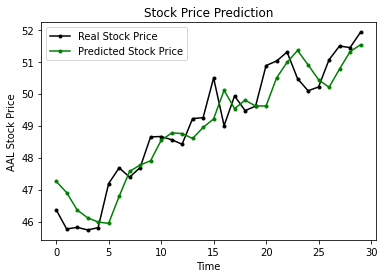

In [34]:
# plot real and predicted prices for AAL Stock
plt.plot(real_stock_price[170:200], marker = '.', color = 'black', label = 'Real Stock Price')
plt.plot(predicted_stock_price[170:200], marker = '.', color = 'green', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AAL Stock Price')
plt.legend()
plt.show()

In [27]:
# evaluate model for test set with AAL data
RLSTM.evaluate([x_test, prevention_module_data_test], y_test, batch_size=32)

8/8 [==============================] - 0s 4ms/step - loss: 0.0031


0.003140467219054699

In [28]:
# test trained model with data from a stock different than the one used in training (obviously these data are unseen)
googl_predicted_stock_price = RLSTM.predict([x_test_googl, googl_prevention_module_data_test])

# inverse transform real and predicted price to plot them in a common diagram
googl_predicted_stock_price = googl_scaler.inverse_transform(googl_predicted_stock_price)
googl_real_stock_price = googl_scaler.inverse_transform(y_test_googl.reshape(-1, 1))

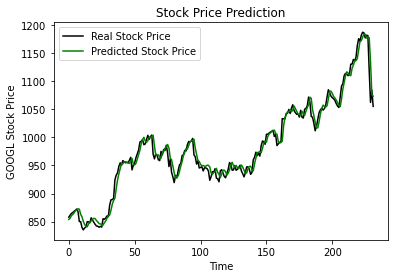

In [29]:
# plot real and predicted prices for AAL Stock
plt.plot(googl_real_stock_price, color = 'black', label = 'Real Stock Price')
plt.plot(googl_predicted_stock_price, color = 'green', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('GOOGL Stock Price')
plt.legend()
plt.show()

In [30]:
# evaluate model for test set with GOOGL data
RLSTM.evaluate([x_test_googl, googl_prevention_module_data_test], y_test_googl, batch_size=32)

8/8 [==============================] - 0s 4ms/step - loss: 0.0012


0.0012184717925265431

In [31]:
# calculate the 3 below errors for evaluation of the model
# these metrics were used also in the paper for where we got the idea of the above model
mse = MeanSquaredError()
mae = MeanAbsoluteError()
mape = MeanAbsolutePercentageError()

# average squared difference between the forecasted and actual values, stability of the model
print('AAL MSE:', mse(real_stock_price, predicted_stock_price).numpy())
print('GOOGL MSE:', mse(googl_real_stock_price, googl_predicted_stock_price).numpy())

print('\n')

# average value of absolute error, which can reflect the actual situation of predicted value error
print('AAL MAE:', mae(real_stock_price, predicted_stock_price).numpy())
print('GOOGL MAE:', mae(googl_real_stock_price, googl_predicted_stock_price).numpy())

print('\n')

# prediction deviation proportion in terms of the real value. A metric for the forecast accuracy
print('AAL MAPE:', mape(real_stock_price, predicted_stock_price).numpy())
print('GOOGL MAPE:', mape(googl_real_stock_price, googl_predicted_stock_price).numpy())

AAL MSE: 1.0311238
GOOGL MSE: 155.88512


AAL MAE: 0.7512699
GOOGL MAE: 8.819756


AAL MAPE: 1.5700872
GOOGL MAPE: 0.8985434
